In [1]:
import os
os.chdir("../..")

import torch
from torchvision import transforms

import cv2
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

import tensorflow as tf

from imagebind import data
from imagebind.models import imagebind_model
from imagebind.models.imagebind_model import ModalityType

from xplique.wrappers import TorchWrapper
from xplique.plots import plot_attributions
from xplique.attributions import (Saliency, GradientInput, IntegratedGradients, SmoothGrad, VarGrad,
                                  SquareGrad, Occlusion, Rise, GuidedBackprop, Lime, KernelShap, SobolAttributionMethod, HsicAttributionMethod)

2024-06-03 02:03:41.625490: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-03 02:03:41.670439: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-03 02:03:42.378617: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/cry/anaconda3/envs/hsic/lib/python3.8/site-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'to

In [2]:
tf.config.run_functions_eagerly(True)

gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)]
)

In [3]:
class ImageBindModel_Super(torch.nn.Module):
    def __init__(self, base_model, device):
        super().__init__()
        self.base_model = base_model
        self.device = device
        
    def mode_selection(self, mode):
        if mode not in ["text", "audio", "thermal", "depth", "imu"]:
            print("mode {} does not comply with the specification, please select from \"text\", \"audio\", \"thermal\", \"depth\", \"imu\".".format(mode))
        else:
            self.mode = mode
            print("Select mode {}".format(mode))
            
    def equip_semantic_modal(self, modal_list):
        if self.mode == "text":
            self.semantic_modal = data.load_and_transform_text(modal_list, self.device)
        elif self.mode == "audio":
            self.semantic_modal = data.load_and_transform_audio_data(modal_list, self.device)
        
        input = {
                # "vision": vision_inputs,
                self.mode: self.semantic_modal
            }
        with torch.no_grad():
            self.semantic_modal = self.base_model(input)[self.mode]
        print("Equip with {} modal.".format(self.mode))
        
    def forward(self, vision_inputs):
        inputs = {
            "vision": vision_inputs,
        }
        
        with torch.no_grad():
            embeddings = self.base_model(inputs)
        
        scores = torch.softmax(embeddings["vision"] @ self.semantic_modal.T, dim=-1)
        return scores
        

In [4]:
def load_and_transform_vision_data(image_paths, device, channel_first=False):
    if image_paths is None:
        return None

    image_outputs = []

    data_transform = transforms.Compose(
        [
            transforms.Resize(
                (224,224), interpolation=transforms.InterpolationMode.BICUBIC
            ),
            # transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=(0.48145466, 0.4578275, 0.40821073),
                std=(0.26862954, 0.26130258, 0.27577711),
            ),
        ]
    )
    
    for image_path in image_paths:
        with open(image_path, "rb") as fopen:
            image = Image.open(fopen).convert("RGB")

        image = data_transform(image).to(device)
        image_outputs.append(image)
    image_outputs = torch.stack(image_outputs, dim=0)
    if channel_first:
        pass
    else:
        image_outputs = image_outputs.permute(0,2,3,1)
    return image_outputs.cpu().numpy()

In [5]:
text_list=["A dog.", "A car.", "A bird.", "An airplane.", "A bicycle.", "A boat.", "A cat.", "A chair", "A cow.", "A diningtable.", "A horse.", "A motorbike.", "A person.", "A pottedplant.", "A sheep.", "A sofa.", "A train.", "A tvmonitor."]
image_paths=[".assets/dog_image.jpg", ".assets/car_image.jpg", ".assets/bird_image.jpg"]
# audio_paths=[".assets/dog_audio.wav", ".assets/car_audio.wav", ".assets/bird_audio.wav"]

In [6]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
# Instantiate model
model = imagebind_model.imagebind_huge(pretrained=True)
model.eval()
model.to(device)

vis_model = ImageBindModel_Super(model, device)
print("ok")

ok


In [7]:
vis_model.mode_selection("text")
vis_model.equip_semantic_modal(text_list)

Select mode text
Equip with text modal.


In [8]:
image_input = load_and_transform_vision_data(image_paths, device)

In [9]:
image_input.shape

(3, 224, 224, 3)

In [11]:
predict_score = vis_model(data.load_and_transform_vision_data(image_paths, device))

In [12]:
X = [cv2.resize(cv2.imread(image_path), (224,224))[..., ::-1] for image_path in image_paths]
# one-hot
Y = np.eye(predict_score.shape[-1])[predict_score.argmax(-1).cpu().numpy()]

In [15]:
predict_score.argmax(-1).cpu().numpy()

array([0, 1, 2])

In [16]:
wrapped_model = TorchWrapper(vis_model.eval(), device)

2024-06-03 02:05:17.889463: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2048 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:17:00.0, compute capability: 8.6
2024-06-03 02:05:17.889904: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 5055 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:b3:00.0, compute capability: 8.6
/home/cry/anaconda3/envs/hsic/lib/python3.8/site-packages/xplique/wrappers/pytorch.py:61: UserWarning: TF is set to run eagerly to avoid conflict with PyTorch. Thus,                       TF functions might be slower
  warnings.warn("TF is set to run eagerly to avoid conflict with PyTorch. Thus,\


In [20]:
image_input.dtype

dtype('float32')

In [21]:
Y.dtype

dtype('float64')

2024-04-07 19:44:05.666094: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [3,18]
	 [[{{node Placeholder/_1}}]]
/home/cry/anaconda3/envs/hsic/lib/python3.8/site-packages/xplique/wrappers/pytorch.py:141: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  torch_inputs = self.torch.Tensor(np_inputs)
2024-04-07 19:44:05.805907: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INF

Method: Occlusion


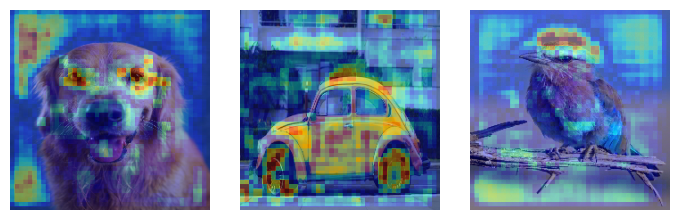

2024-04-07 19:46:14.926162: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype bool and shape [4000,7,7,1]
	 [[{{node Placeholder/_0}}]]
2024-04-07 19:47:47.695642: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype bool and shape [4000,7,7,1]
	 [[{{node Placeholder/_0}}]]
2024-04-07 19:49:20.016889: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype bool and shape

Method: Rise


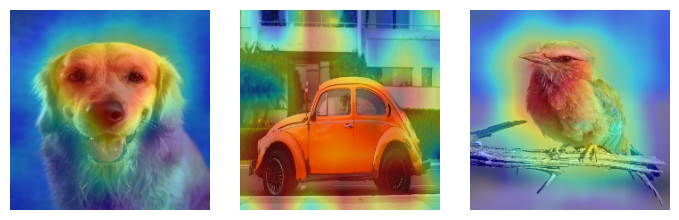

2024-04-07 19:50:52.638808: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [2112,8,8,1]
	 [[{{node Placeholder/_0}}]]
2024-04-07 19:51:41.104996: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [2112,8,8,1]
	 [[{{node Placeholder/_0}}]]
2024-04-07 19:52:29.477611: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and sh

Method: SobolAttributionMethod


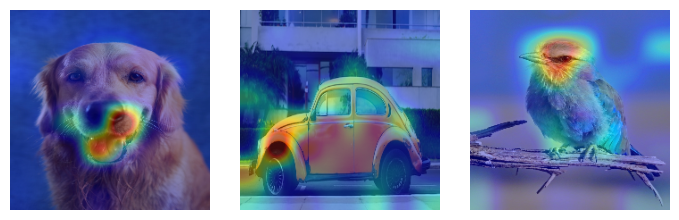

2024-04-07 19:53:18.104330: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [500,8,8,1]
	 [[{{node Placeholder/_0}}]]
2024-04-07 19:53:29.599466: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [64,1,1,500]
	 [[{{node Placeholder/_1}}]]
2024-04-07 19:53:29.609363: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-04-07 19:53:29.620784: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor sta

Method: HsicAttributionMethod


2024-04-07 19:53:52.512989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [64,1,1,500]
	 [[{{node Placeholder/_1}}]]


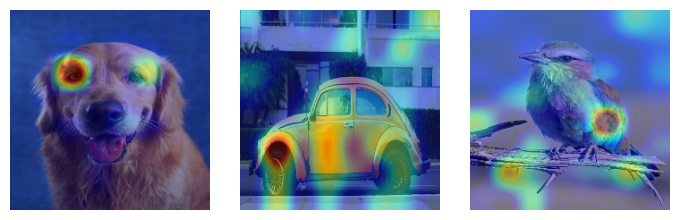

2024-04-07 19:53:52.712933: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [3,18]
	 [[{{node Placeholder/_1}}]]


2024-04-07 19:53:52.876675: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32 and shape [4000,753]
	 [[{{node Placeholder/_0}}]]
2024-04-07 19:55:27.061640: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32 and shape [4000,1389]
	 [[{{node Placeholder/_0}}]]
2024-04-07 19:57:01.267823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32 and shape

Method: Lime


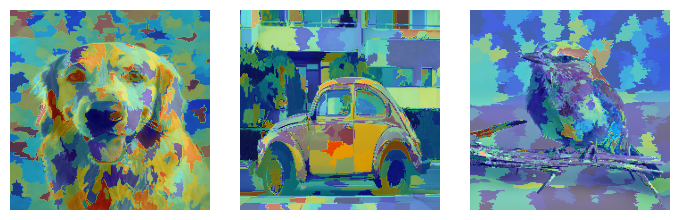

2024-04-07 19:59:14.859206: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [3,18]
	 [[{{node Placeholder/_1}}]]
2024-04-07 19:59:15.055595: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32 and shape [4000,753]
	 [[{{node Placeholder/_0}}]]
2024-04-07 20:00:54.118472: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32 and shape [400

Method: KernelShap


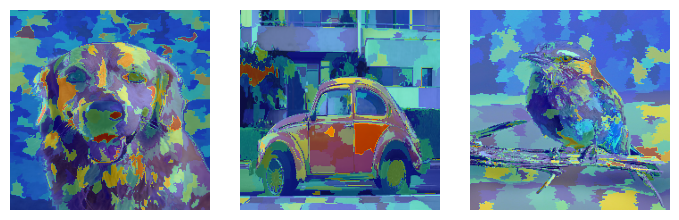

In [13]:
# set batch size parameter
batch_size = 16

# build the explainers
explainers = [
  # Saliency(wrapped_model),
  # GradientInput(wrapped_model),
  # IntegratedGradients(wrapped_model, steps=80, batch_size=batch_size),
  # SmoothGrad(wrapped_model, nb_samples=80, batch_size=batch_size),
  # SquareGrad(wrapped_model, nb_samples=80, batch_size=batch_size),
  # VarGrad(wrapped_model, nb_samples=80, batch_size=batch_size),
  Occlusion(wrapped_model, patch_size=10, patch_stride=5, batch_size=batch_size),
  Rise(wrapped_model, nb_samples=4000, batch_size=batch_size),
  SobolAttributionMethod(wrapped_model, batch_size=batch_size),
  HsicAttributionMethod(wrapped_model, batch_size=batch_size),
  Lime(wrapped_model, nb_samples = 4000, batch_size=batch_size),
  KernelShap(wrapped_model, nb_samples = 4000, batch_size=batch_size)
]

for explainer in explainers:

  explanations = explainer(image_input, Y)

  print(f"Method: {explainer.__class__.__name__}")
  plot_attributions(explanations, X, img_size=2., cmap='jet', alpha=0.4,
                    cols=len(X), absolute_value=True, clip_percentile=0.5)
  plt.show()
  print("\n")